# NASDAQ companies documents EDA


In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
import boto3
import pandas as pd
import numpy as np
from download_sample import download_s3_folder
from text_normalizer import normalize_corpus, normalize_text, remove_tokenized_stopwords
from visualization import make_wordcloud
from dotenv import load_dotenv
from haystack.utils import convert_files_to_docs
from nltk import FreqDist
from nltk.tokenize import ToktokTokenizer
from itertools import chain
from collections import Counter


The first step of any project related to data is understanding our data. The dataset corresponds to PDF documents that contain financial information about NASDAQ companies. Let's find out how big is our dataset.


In [3]:
load_dotenv()

s3 = boto3.resource(
    "s3",
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY"),
    aws_secret_access_key=os.getenv("AWS_SECRET_KEY"),
)

In [4]:
bucket = s3.Bucket("anyoneai-datasets")
objects = bucket.objects.filter(Prefix="nasdaq_annual_reports")
size_byte = 0
counter = 0
for obj in objects:
    size_byte += obj.size
    counter += 1
print(f"Total dataset size: {round(size_byte/1000/1024/1024, 2)} GB")
print(f"Total documents: {counter}")

Total dataset size: 30.51 GB
Total documents: 9857


It is also important to know how many companies conform the dataset


In [8]:
obj_keys = [obj.key for obj in objects]
companies = []
for key in obj_keys:
    if len(key.split("/")) > 2:
        companies.append(key.split("/")[1])
print(f"Number of companies: {len(set(companies))}")

Number of companies: 2428


As well as what are the companies with the most files

In [49]:
company_file_count=Counter(companies)

company_file_count.most_common(10)

[('21vianet-group-inc', 5),
 ('3d-systems-corp', 5),
 ('51job-inc', 5),
 ('9-meters-biopharma-inc', 5),
 ('BRPInc', 5),
 ('DBV', 5),
 ('ICU-medical-Incorporated', 5),
 ('Independent-bank-corp', 5),
 ('Independent-bank-corporation', 5),
 ('Independent-bank-group-Inc', 5)]

Now, how many companies have actually have five files?

In [48]:
for i, (_, count) in enumerate(company_file_count.most_common(1000)):
    if count==4:
        print(f'Companies with 5 files: {i}')
        break

Companies with 5 files: 680


If 680 companies have 5 files, that is equal to 3400 files. This means that about a third of all files belong to the top 28% of companies by number of files 

## Downloading files

Since the total dataset size is +30 GB, we will work with a small random sample of the data for further analysis. Also, the size of this dataset makes it necessary to process it in batches. For now, let's just focus on a sample.


In [14]:
download_s3_folder(
    "anyoneai-datasets", "nasdaq_annual_reports", os.path.join(os.getcwd(), "dataset")
)

Now that we have downloaded a sample, let's convert the documents to text, normalize and tokenize the texts.


In [6]:
all_docs = convert_files_to_docs(dir_path="./dataset", clean_func=normalize_text)

In [9]:
docs_text = [doc.content for doc in all_docs if len(doc.content) > 15]

In [11]:
tokenizer = ToktokTokenizer()
tokenized_text = [tokenizer.tokenize(text) for text in docs_text]

## Texts statistics


With our documents in text form, let's explore some facts about our documents. For example, the average number of characters and words


In [78]:
print(f"Average number of characters: {round(np.mean(list(map(len, docs_text))))}")

Average number of characters: 413173


In [79]:
print(f"Average number of words: {round(np.mean(list(map(len, tokenized_text))))}")

Average number of words: 63874


Now, let's see how rich the vocabulary of our documents is. For that we will use a metric called lexical richness. Which we calculate using the formula:
$$ R_l = \frac{\text{total unique words}}{\text{total words}}$$


In [19]:
def lexical_richness(text):
    return len(set(text)) / len(text)

In [15]:
text_df = pd.DataFrame(columns=["text", "lexical_richness"])
text_df["text"] = tokenized_text
text_df["lexical_richness"] = text_df["text"].apply(lexical_richness)
text_df["normalized_text"] = text_df["text"].apply(remove_tokenized_stopwords)

In [62]:
text_df["lexical_richness"].describe()

count    99.000000
mean      0.095719
std       0.094042
min       0.040705
25%       0.055308
50%       0.065748
75%       0.078214
max       0.530165
Name: lexical_richness, dtype: float64

Notice that the average and the standard deviation are nearly the same. This is due to the max value of 0.53, which is an outlier. Let's consider instead the median value of 0.07. This indicates that the texts do not possess a highly rich vocabulary.


## Distribution of text content


Now we should explore what are the most common words (or collocations) in our texts. This will give us a general idea of the content of the texts.


In [58]:
dist = FreqDist(list(chain(*text_df["normalized_text"])))

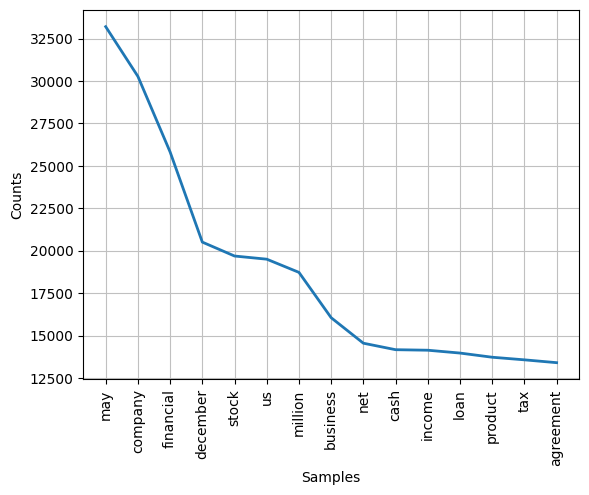

<Axes: xlabel='Samples', ylabel='Counts'>

In [61]:
dist.plot(15)

The appearance of the word "may" probably refers to the modal verb rather than the month. Aside from that, the other words make sense considering that the documents correspond to anual financial statements.

Let's now investigate the most common collocations (predictable combinations of words).


In [33]:
stopword_removed = normalize_corpus(
    docs_text,
    contraction_expansion=False,
    accented_char_removal=False,
    text_lower_case=False,
    text_stemming=False,
    special_char_removal=False,
    remove_digits=False,
)


In [ ]:
flattened_corpus = " ".join(stopword_removed)

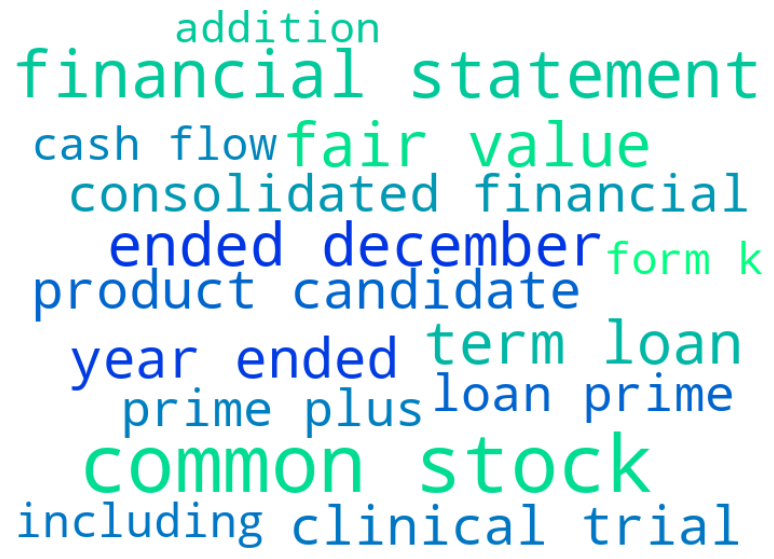

In [45]:
make_wordcloud(flattened_corpus, collocations=True, stopwords=["united", "state"])

The most meaningful collocations are "financial statement" (which is what the documents are all about), and "common stock" which is the type of stock that gives voting rights.
